<a href="https://colab.research.google.com/github/eddietseng1129/machine_learning/blob/master/Birds_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Download data
!wget http://www.vision.caltech.edu/visipedia-data/CUB-200-2011/CUB_200_2011.tgz
# Uncompress files
!tar xvzf CUB_200_2011.tgz


In [0]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import random
import gc

from pathlib import Path

In [0]:
# BGR -> RGB
def read_image(path):
    im = cv2.imread(str(path))
    return cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

In [4]:
PATH = Path('./CUB_200_2011')
labels = pd.read_csv(PATH/"image_class_labels.txt", header=None, sep=" ")
labels.columns = ["id", "label"]
labels.head(2)

,id,label
0,1,1
1,2,1


In [5]:
train_test = pd.read_csv(PATH/"train_test_split.txt", header=None, sep=" ")
train_test.columns = ["id", "is_train"]
train_test.head(2)

,id,is_train
0,1,0
1,2,1


In [6]:
images = pd.read_csv(PATH/"images.txt", header=None, sep=" ")
images.columns = ["id", "name"]
images.head(2)

,id,name
0,1,001.Black_footed_Albatross/Black_Footed_Albatr...
1,2,001.Black_footed_Albatross/Black_Footed_Albatr...


In [7]:
classes = pd.read_csv(PATH/"classes.txt", header=None, sep=" ")
classes.columns = ["id", "class"]
classes.head(2)

,id,class
0,1,001.Black_footed_Albatross
1,2,002.Laysan_Albatross


In [8]:
categories = [x for x in classes["class"]]
len(categories)

200

In [0]:
nrows, ncols = 299, 299
channels = 3

def read_process_images(files_path, labels, train_test, image_name, train=True):
  """
    Return two arrays:
      X is an array of resized images
      y is an array of labels
  """
  if train:
    mask = train_test.is_train.values == 1
  else:
    mask = train_test.is_train.values == 0

  filenames = image_name.iloc[mask]
  labels = labels.iloc[mask]
  num_files = labels.shape[0]
  X = []
  y = list(labels['label'])
  for image in filenames['name']:
    X.append(cv2.resize(read_image(str(files_path) + '/images/' + image), (nrows, ncols), interpolation=cv2.INTER_CUBIC))

  return X, y

In [0]:
X, y = read_process_images(PATH, labels, train_test, images)

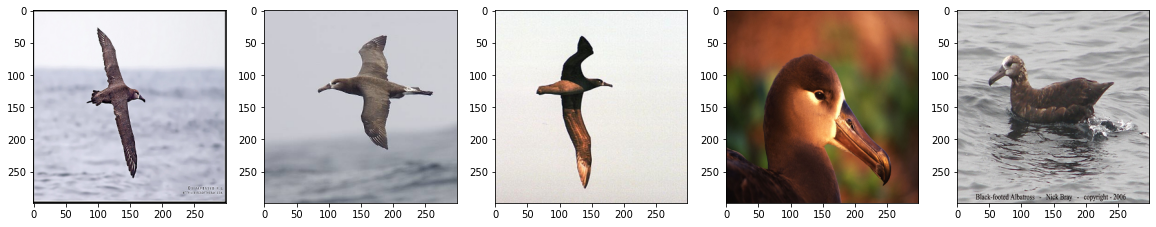

In [11]:
plt.figure(figsize=(20,10))
columns=5
for i in range(columns):
  plt.subplot(5/columns+1, columns, i + 1)
  plt.imshow(X[i])

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Text(0.5, 1.0, 'Labels for Birds')

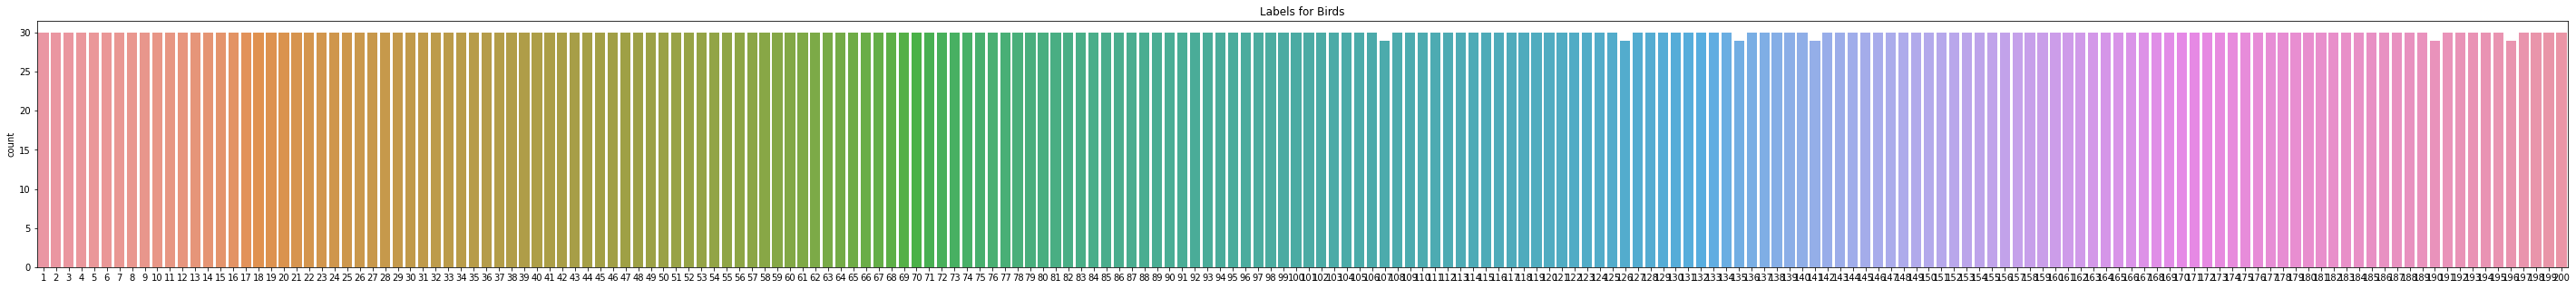

In [12]:
import seaborn as sns
X = np.array(X)
y = np.array(y)

plt.figure(figsize=(50,5))
sns.countplot(y)
plt.title('Labels for Birds')

In [13]:
print("Shape of train images: ", X.shape)
print("Shape of labels: ", y.shape)

Shape of train images:  (5994, 299, 299, 3)
Shape of labels:  (5994,)


In [14]:
import tensorflow as tf
from keras.utils import to_categorical
from keras.optimizers import Adam, RMSprop, SGD
from keras.models import Model
from keras.layers import Dense,GlobalAveragePooling2D, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array, load_img
from keras.applications import ResNet50V2, InceptionV3
from sklearn.model_selection import train_test_split

batch_size = 32
NUM_EPOCHS = 100
NUM_CLASSES = 200
IMG_SHAPE = (ncols, nrows, 3)

y = to_categorical(y-1)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=2)

ntrain = len(X_train)
nval = len(X_val)

print(X.shape)
print(y.shape)

Using TensorFlow backend.


(5994, 299, 299, 3)
(5994, 200)


In [15]:
# base_model = ResNet50V2(input_shape=IMG_SHAPE, weights='imagenet', include_top=False)
base_model = InceptionV3(input_shape=IMG_SHAPE, weights='imagenet', include_top=False)

x = base_model.output
x = GlobalAveragePooling2D()(x)
# x = Dropout(0.5)(x)
# x = Dense(1024,activation='relu')(x) # add dense layers so that the model can learn more complex functions and classify for better results.
x = Dropout(0.5)(x)
x = Dense(1024,activation='relu')(x) # dense layer 2
# x = Dropout(0.25)(x)
# x = Dense(512,activation='relu')(x) # dense layer 3
preds = Dense(NUM_CLASSES,activation='softmax')(x) #final layer with softmax activation

model = Model(inputs=base_model.input,outputs=preds)

base_model.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
# model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
# # train the model on the new data for a few epochs
# model.fit(X_train, y_train, batch_size=batch_size, epochs=3, validation_data=(X_val, y_val))

# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
for layer in model.layers[:249]:
    layer.trainable=False
for layer in model.layers[249:]:
    layer.trainable=True

# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate=1e-2,
#     decay_steps=1000,
#     decay_rate=0.9)

model.compile(loss="categorical_crossentropy", optimizer=SGD(lr=0.0001), metrics=['accuracy'])

# model.summary()

87916544/87910968 [==============================] - 1s 0us/step


In [0]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,)
val_datagen = ImageDataGenerator(rescale= 1./255,)

In [0]:
# clear memory
try:
  del X
  del y
  gc.collect()
except:
  pass

train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size)
val_generator = val_datagen.flow(X_val, y_val, batch_size=batch_size)

history = model.fit_generator(train_generator, 
                              steps_per_epoch = ntrain // batch_size,
                              epochs = NUM_EPOCHS,
                              validation_data = val_generator,
                              validation_steps = nval // batch_size)

Epoch 1/100
149/149 [==============================] - 99s 663ms/step - loss: 5.4592 - accuracy: 0.0052 - val_loss: 5.3970 - val_accuracy: 0.0084
Epoch 2/100
149/149 [==============================] - 88s 594ms/step - loss: 5.4482 - accuracy: 0.0057 - val_loss: 5.2773 - val_accuracy: 0.0086
Epoch 3/100
149/149 [==============================] - 88s 591ms/step - loss: 5.4382 - accuracy: 0.0059 - val_loss: 5.3217 - val_accuracy: 0.0086
Epoch 4/100
149/149 [==============================] - 88s 587ms/step - loss: 5.4413 - accuracy: 0.0038 - val_loss: 5.4045 - val_accuracy: 0.0094
Epoch 5/100
149/149 [==============================] - 86s 580ms/step - loss: 5.4298 - accuracy: 0.0061 - val_loss: 5.2783 - val_accuracy: 0.0086
Epoch 6/100
149/149 [==============================] - 86s 580ms/step - loss: 5.4346 - accuracy: 0.0046 - val_loss: 5.2820 - val_accuracy: 0.0077
Epoch 7/100
149/149 [==============================] - 86s 576ms/step - loss: 5.4175 - accuracy: 0.0061 - val_loss: 5.2829 -

In [0]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, NUM_EPOCHS + 1)

plt.plot(epochs, acc, 'b', label = "Training Accuracy")
plt.plot(epochs, val_acc, 'r', label = "Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'b', label = "Training Loss")
plt.plot(epochs, val_loss, 'r', label = "Validation Loss")
plt.title("Training and Validation Loss")
plt.legend()

plt.show()